# <center> 作业二 Food-11 </center>
by Hyr1sky_He

_为了提高任务效率，本ipynb中不再细化每个步骤的操作过程，仅记录重要思路及核心方法，Task题目解答将在实验报告中给出_

In [2]:
import numpy as np
import pandas as pd
import torch
import time
import os
import cv2
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm.auto import tqdm
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the train model
"""
model = classifier().to(device)
state_dict = torch.load('model.pth')
model.load_state_dict(state_dict)
model.eval()

print(model)
"""

"\nmodel = classifier().to(device)\nstate_dict = torch.load('model.pth')\nmodel.load_state_dict(state_dict)\nmodel.eval()\n\nprint(model)\n"

## 数据加载

由0到10分别为：\
Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit.

In [11]:
# 读入数据
data_dir = Path('../Assignment2_dataset/food-11')
train_dir = data_dir / 'training'
val_dir = data_dir / 'validation'
test_dir = data_dir / 'testing'

def readfile(path,own_label):#后面的参数用来区分训练集和测试集
    image_dir = sorted(os.listdir(path)) #对path下的文件进行排序后输出
    x = np.zeros((len(image_dir),128,128,3),dtype=np.uint8) #初始化，用来保存训练数据
    y = np.zeros((len(image_dir)),dtype=np.uint8) #初始化，用来保存label
    for i,file in enumerate(image_dir): #循环，将图片信息保存到x,y
        # 读取image
        img = Image.open(os.path.join(path,file))
        # 将image Resize成(128, 128)
        x[i,:,:] = np.array(img.resize((128,128))).astype(np.uint8)
        if own_label: #此处来判断是训练还是测试，True为训练，False为测试
            y[i] = int(file.split("_")[0]) #如果是True,则给y赋值，文件名的第一个数
    if own_label:#有label，返回x,y
        return x,y
    else:#无label，返回x
        return x

In [12]:
# Load the dataset.
#分别读取训练、验证和测试的数据，保存到相应的变量里
train_x, train_y = readfile(train_dir, True)
print("Size of training data = {}".format(len(train_x)))
val_x ,val_y = readfile(val_dir, True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(test_dir, False)
print("Size of Testing data = {}".format(len(test_x)))

"""
train_set = DatasetFolder(train_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=train_transform)
valid_set = DatasetFolder(val_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=test_transform)
unlabeled_set = DatasetFolder(, loader=lambda x: Image.open(x), extensions="jpg", transform=train_transform)
test_set = DatasetFolder(test_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=test_transform)
"""
# Construct data loaders.
"""
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
"""

Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


'\ntrain_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)\nvalid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)\ntest_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)\n'

## 数据读入与处理的函数

In [6]:
mean = np.mean([np.array(img, dtype = np.float32) / 255.0 for img in train_x] +
               [np.array(img, dtype = np.float32) / 255.0 for img in val_x], axis=(0, 1, 2))
std = np.std([np.array(img, dtype = np.float32) / 255.0 for img in train_x] + 
             [np.array(img, dtype = np.float32) / 255.0 for img in val_x], axis=(0, 1, 2))

print("Mean of Train Data = {}".format(mean))
print("Std of Train Data = {}".format(std))

Mean of Train Data = [0.07701565 0.07701565 0.07701565]
Std of Train Data = [0.27751693 0.27751693 0.27751693]


## 关于Transform
[torchvision.transforms 常用方法解析（含图例代码以及参数解释）](https://blog.csdn.net/weixin_42426841/article/details/129903800)

In [6]:
# transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128, scale=(0.5, 1.0), ratio=(1.0, 1.0)),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std), 仅在train中加入标准化会导致val的acc极低
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 128

In [8]:
# 数据集类处理
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

## 展示图片与变换

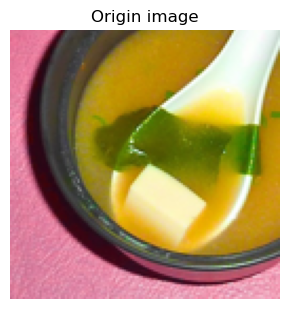

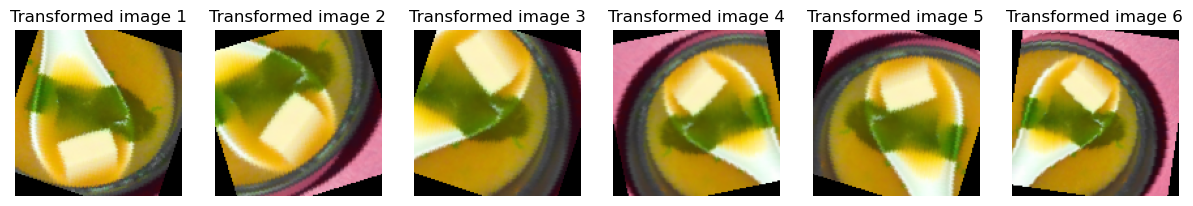

In [9]:
TFM_N = 6

# 随机取出一张图片，显示原图和变换后的图片
idx = np.random.randint(0, len(train_x))
origin_img = train_x[idx]
# origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 3.5))
plt.title('Origin image')
plt.imshow(origin_img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 3.5))
for i in range(TFM_N):
    tfm_img = train_transform(origin_img)
    plt.subplot(1, TFM_N, i+1)
    plt.title(f"Transformed image {i + 1}")
    plt.imshow(tfm_img.permute(1, 2, 0))
    plt.axis('off')
plt.show()

## 数据读入

In [10]:
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
test_set = ImgDataset(test_x, None, test_transform)

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

## 做一个小的数据切片来实验

In [39]:
"""
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347
"""

MINISIZE_1 = 3000
MINISIZE_2 = 900

random_sample_1 = np.random.randint(0, len(train_set), size=MINISIZE_1)
random_sample_2 = np.random.randint(0, len(val_set), size=MINISIZE_2)
train_miniset = Subset(train_set, random_sample_1)
val_miniset = Subset(val_set, random_sample_2)
# test_miniset = Subset(test_set, random_sample_2)

# 序号重排
train_miniset.indices = np.arange(len(train_miniset))
val_miniset.indices = np.arange(len(val_miniset))
# test_miniset.indices = np.arange(len(test_miniset))

"""
minitrain_x = train_miniset.dataset.x[train_miniset.indices]
minitrain_y = train_miniset.dataset.y[train_miniset.indices]
minival_x = val_miniset.dataset.x[val_miniset.indices]
minival_y = val_miniset.dataset.y[val_miniset.indices]
minitest_x = test_miniset.dataset.x[test_miniset.indices]
"""

print("Size of mini training data = {}".format(len(train_miniset)))
print("Size of mini validation data = {}".format(len(val_miniset)))
# print("Size of mini testing data = {}".format(len(test_miniset)))

minitrain_loader = DataLoader(train_miniset, batch_size = batch_size, shuffle = True)
minival_loader = DataLoader(val_miniset, batch_size = batch_size, shuffle = False)
# minitest_loader = DataLoader(test_miniset, batch_size = batch_size, shuffle = False)

Size of mini training data = 3000
Size of mini validation data = 900


In [10]:
# 随机查看minitrain数据集中的图片
idx = np.random.randint(0, len(train_miniset))
origin_img = train_miniset.dataset.x[idx]
# origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 3.5))
plt.title('Origin image')
plt.imshow(origin_img)
plt.axis('off')
plt.show()

# 查看tensor维度
print(origin_img.shape)

NameError: name 'train_miniset' is not defined

## 模型

In [13]:
# CNN
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )

        # fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        #
        out = self.CNN(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)

        return out

In [3]:
# VGG19
from torchvision.models import vgg19

class Classifier_VGG19(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN = vgg19(weights=None, num_classes=11)
        self.CNN = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )

        # fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

        # fully connected layers

    def forward(self, x):
        #
        out = self.CNN(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)

        return out   

In [4]:
print(Classifier_VGG19())

Classifier_VGG19(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.1, inplace=False)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 

In [33]:
# VGG16
from torchvision.models import vgg16

class Classifier_VGG16(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN = vgg16(weights=None, num_classes=11)
        self.CNN = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )

        # fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

        # fully connected layers

    def forward(self, x):
        #
        out = self.CNN(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

In [32]:
print(Classifier_VGG16())

Classifier_VGG16(
  (CNN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.1, inplace=False)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 

In [55]:
# ResNet18
from torchvision.models import resnet18

class Classifier_ResNet18(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN = resnet18(weights=None, num_classes=11)
        self.CNN = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            # nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            # nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            # nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            # nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            # nn.Dropout(0.1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )

        # fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            # nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

        # fully connected layers

    def forward(self, x):
        #
        out = self.CNN(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

In [16]:
print("CUDA Available:",torch.cuda.is_available())

CUDA Available: True


## Early Stopping

In [28]:
# Early Stopping

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience  # 没有改善的训练轮数
        self.verbose = verbose  # 是否打印出每一次改善
        self.counter = 0  # 记录没有改善的训练轮数
        self.best_score = None  # 记录最好的验证集性能
        self.early_stop = False  # 是否停止训练
        self.delta = delta  # 改善的阈值
        self.path = path  # 保存模型的文件路径

    def __call__(self, val_loss, model):
        score = -val_loss  # 如果是准确率，将其变为负数

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    # def early_stop(self):
    #    return self.early_stop

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  # 保存最好的模型权重

## Train

In [56]:
from sklearn.model_selection import StratifiedKFold

num_splits = 5
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

In [57]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs/CNN')

#训练过程
model = Classifier_ResNet18().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) # LR
num_epoch = 30
# early_stopping = EarlyStopping(patience=5, verbose=True) #Early Stopping

#开始训练
for epoch in range(num_epoch):
    
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # Training
    model.train()
    for i,data in enumerate(minitrain_loader):
        optimizer.zero_grad()
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred,data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(),axis=1)==data[1].numpy())
        train_loss += batch_loss.item()
        
        writer.add_scalar('Loss/train', train_loss/train_miniset.__len__(), epoch)
        writer.add_scalar('Acc/train', train_acc/train_miniset.__len__(), epoch)

        # Early Stopping
        """
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        """

    # Validation
    model.eval()
    with torch.no_grad():
        for i,data in enumerate(minival_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred,data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
        
        print('[%03d/%03d] %2.2f sec(s) Train Acc:%3.6f Loss:%3.6f | Val Acc:%3.6f loss:%3.6f' %\
                (epoch + 1,num_epoch,time.time()-epoch_start_time,\
                train_acc/train_miniset.__len__(),train_loss/train_miniset.__len__(),val_acc/val_miniset.__len__(),val_loss/val_miniset.__len__()))


KeyboardInterrupt: 

## 交叉验证

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs/CNN')

loss = nn.CrossEntropyLoss()
num_epoch = 30

# 训练过程
for fold, (train_idx, val_idx) in enumerate(skf.split(train_x, train_y)):
    print(f"Fold {fold + 1}/{num_splits}")

    # 创建模型和优化器
    model = Classifier_ResNet18().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 划分数据为训练集和验证集
    train_features_fold = train_x[train_idx]
    train_labels_fold = train_y[train_idx]
    val_features_fold = train_x[val_idx]
    val_labels_fold = train_y[val_idx]

    # 创建数据加载器
    train_fold_dataset = ImgDataset(train_features_fold, train_labels_fold, transform = train_transform)
    val_fold_dataset = ImgDataset(val_features_fold, val_labels_fold, transform = test_transform)

    train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)

    # 开始训练
    for epoch in range(num_epoch):

        epoch_start_time = time.time()
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        for i,data in enumerate(minitrain_loader):
            optimizer.zero_grad()
            train_pred = model(data[0].cuda())
            batch_loss = loss(train_pred,data[1].cuda())
            batch_loss.backward()
            optimizer.step()

            train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(),axis=1)==data[1].numpy())
            train_loss += batch_loss.item()
            
            writer.add_scalar('Loss/train', train_loss/train_miniset.__len__(), epoch)
            writer.add_scalar('Acc/train', train_acc/train_miniset.__len__(), epoch)

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_fold_loader):
                val_pred = model(data[0].cuda())
                batch_loss = loss(val_pred, data[1].cuda())

                val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                val_loss += batch_loss.item()

            val_accuracy = val_acc / len(val_idx)
            val_loss /= len(val_idx)
            print('[%03d/%03d] %2.2f sec(s) Train Acc:%3.6f Loss:%3.6f | Val Acc:%3.6f loss:%3.6f' %\
                (epoch + 1,num_epoch,time.time()-epoch_start_time,\
                train_acc/train_miniset.__len__(),train_loss/train_miniset.__len__(),val_acc/val_miniset.__len__(),val_loss/val_miniset.__len__()))
            
            writer.add_scalar(f'Accuracy/Fold{fold+1}', val_accuracy, epoch)

    # 存储这个fold的指标
    # fold_metrics.append({'accuracy': val_accuracy, 'loss': val_loss})

## TensorBoard

In [8]:
from tensorboard import notebook
notebook.display(port=6006, height=1000)
%tensorboard --logdir ./runs/RessNet18

UsageError: Line magic function `%tensorboard` not found.


## 混淆矩阵

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix
train_cfm = torch.zeros(11, 11)
val_cfm = torch.zeros(11, 11)

model.eval()

with torch.no_grad():
    """ Train
    for i, data in enumerate(tqdm(minitrain_loader)):
        train_pred = model(data[0].cuda())
        train_label = data[1].cuda()
        _, train_pred = torch.max(train_pred, 1)
        for j in range(len(train_label)):
            train_cfm[train_label[j], train_pred[j]] += 1
    """
    for i, data in enumerate(tqdm(minival_loader)):
        val_pred = model(data[0].cuda())
        val_label = data[1].cuda()
        _, val_pred = torch.max(val_pred, 1)
        for j in range(len(val_label)):
            val_cfm[val_label[j], val_pred[j]] += 1
    

plt.figure(figsize=(10, 8))
sns.heatmap(val_cfm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

NameError: name 'model' is not defined

## 合并

In [20]:
train_val_x = np.concatenate((train_x,val_x),axis=0) #合并训练集和验证集的X
train_val_y = np.concatenate((train_y,val_y),axis=0) #合并训练集和验证集的Y
train_val_set = ImgDataset(train_val_x,train_val_y,train_transform) #实例化
train_val_loader = DataLoader(train_val_set,batch_size=batch_size,shuffle=True) #载入数据

model_best = Classifier().cuda() #此处的Classifier应该是你自己调整后，网络结构最好的网络
loss = nn.CrossEntropyLoss() #损失函数
optimizer = torch.optim.Adam(model_best.parameters(),lr=0.001) #优化函数
num_epoch = 30 #训练次数

#开始训练
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i,data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred,data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    #输出结果
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

KeyboardInterrupt: 

## Test

In [ ]:
model.eval() #不启用 BatchNormalization 和 Dropout
prediction = [] #新建列表，用来保存测试结果
with torch.no_grad(): #不求导
    for i,data in enumerate(test_loader):
        test_pred = model(data.cuda()) #前馈(预测)
        test_label = np.argmax(test_pred.cpu().data.numpy(),axis=1) #即预测的label
        for y in test_label:
            prediction.append(y)

## 保存

In [ ]:
with open("mini_predict.csv",'w') as f:
    f.write('Id,Categroy\n')
    for i,y in enumerate(prediction):
        f.write('{},{}\n'.format(i,y))